# ACNets: Confirmatory Factor Analysis

We use dosenbach2007 and dosenbach2010 networks in a confirmatory factor analysis.

In [18]:
ATLAS = 'dosenbach2010'
CONNECTIVITY_MEASURE = 'tangent'
FIT_ONLY_INTER_NETWORK_CONNECTIVITIES = True
BINARIZE_CONNECTIVITIES = False

## Setup

In [19]:

import math
import re

import numpy as np
import xarray as xr
import pandas as pd

from IPython.display import clear_output
import matplotlib.pyplot as plt
import seaborn as sns; sns.set('notebook')

from sklearn import preprocessing, model_selection, metrics, ensemble, multioutput
from sklearn import decomposition, cross_decomposition, feature_selection, dummy, svm

from sklearn.pipeline import Pipeline

from nilearn import datasets as nilean_datasets

import skopt
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical

from python.acnets.datasets import load_connectivity

from copy import deepcopy

from tqdm import tqdm

from factor_analyzer import ConfirmatoryFactorAnalyzer, ModelSpecificationParser

# Technical reproducibility
%reload_ext watermark
%watermark -iv -co -ituhmv

%reload_ext autoreload
%autoreload 3

Last updated: 2022-02-24T13:50:20.715077+01:00

Python implementation: CPython
Python version       : 3.9.10
IPython version      : 8.0.1

conda environment: acnets

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 21.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

Hostname: MP0159

numpy     : 1.21.5
sys       : 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:28:27) 
[Clang 11.1.0 ]
matplotlib: 3.5.1
sklearn   : 1.0.2
re        : 2.2.1
xarray    : 0.21.1
seaborn   : 0.11.2
shap      : 0.40.0
nilearn   : 0.9.0
skopt     : 0.9.0
pandas    : 1.4.0



In [20]:
cv = model_selection.StratifiedKFold(5)

pipe = Pipeline([
  ('zv', feature_selection.VarianceThreshold()),
  ('clf', svm.SVC(kernel='linear', probability=True))
])

param_space = {
  'clf__C': Real(1e-3, 1e3, 'log-uniform'),
}

opt = BayesSearchCV(pipe, param_space, cv=cv, n_jobs=1, scoring='roc_auc')


## Data

X is a 2D matrix of size (n_subjects, n_features), where features are the connectivity measures, e.g., correlation.

We first load the data and preprocess it, i.e., binarize the X.

In [21]:
X, y, feature_names = load_connectivity(
  parcellation=ATLAS,
  kind=CONNECTIVITY_MEASURE,
  vectorize=False,
  return_y=True,
  only_diagonal=False,
  return_feature_names=True,
  discard_diagonal=False,
  discard_cerebellum=False,)

# binarize X by median ± std threshold
if BINARIZE_CONNECTIVITIES:
  X_bin = []
  for X_subj in X:
    threshold = np.median(X_subj) + np.std(X_subj)
    X_subj_bin = preprocessing.Binarizer(threshold=threshold).transform(np.abs(X_subj))
    X_bin.append(X_subj_bin)
  X = np.array(X_bin)

# encode ys as integers
y_encoder = preprocessing.LabelEncoder()
y = y_encoder.fit_transform(y)

Then, extract network names from the atlas. `network_names` is data frame in that `reigon`s are mapped to `network`.

In [22]:
if ATLAS.lower() == 'dosenbach2010':
  coords = nilean_datasets.fetch_coords_dosenbach_2010(legacy_format=False)
  network_names = pd.concat(
    [coords['rois'].reset_index(drop=True),
     pd.Series(coords['labels']),
     coords['networks'].reset_index(drop=True)], axis=1)
  network_names.set_index(0, inplace=True)
  network_names.index.name = 'region'

elif ATLAS.lower() == 'dosenbach2007':
  network_names = pd.read_csv('data/dosenbach2007/ROIS.csv', index_col=0)


## Confirmatory factor analysis
Now, we programmatically define the factor model. Factor model is a dictionary that maps latent factors, i.e., brain networks, to the observable variables, i.e., node features within the brain networks.

We then fit the factor model to the data and extract the factor loadings.

In [23]:
def get_factor_name(feature, network_names=network_names):
  """Get factor given observable variable name."""

  if not '↔' in feature:
    return network_names.loc[feature, 'network']
  
  src, tgt = feature.split(' ↔ ')
  src_net = network_names.loc[src, 'network']
  tgt_net = network_names.loc[tgt, 'network']
  if src_net == tgt_net:
    return src_net
  else:
    return '{} ↔ {}'.format(src_net, tgt_net)


net_feature_names = feature_names.applymap(get_factor_name, network_names=network_names)
net_feature_names = net_feature_names.values[np.triu_indices_from(net_feature_names.values, k=1)]

factors_model = dict.fromkeys(pd.Series(net_feature_names).unique(), [])

unique_feature_names = feature_names.values[np.triu_indices_from(feature_names.values, k=1)]

for feat_name in unique_feature_names:
  net_name = get_factor_name(feat_name)
  factors_model[net_name] = factors_model[net_name] + [feat_name]

# flatten X and feature names into 2D and 1D arrays
_X2d = np.array([x[np.triu_indices_from(x, k=1)] for x in X])
_feature_names_1d = feature_names.values[np.triu_indices_from(feature_names.values, k=1)]

# store flattened X along with the feature names in a dataframe
X_df = pd.DataFrame(_X2d, columns=_feature_names_1d)

The factor model analyzer uses SciPy optimizer under the hood. It's slow for our data, so we limit the features to those within the networks and discard intra-network connections. This will produce a dataset of 118 features.

In [24]:
if FIT_ONLY_INTER_NETWORK_CONNECTIVITIES:
  _control_networks = ['cerebellum', 'cingulo-opercular', 'fronto-parietal']
  factors_model = {k:v for k,v in factors_model.items() if ('↔' not in k) and (k in _control_networks)}
  feature_names = []

  for network, v in factors_model.items():
    feature_names.extend(v)

  feature_names = list(set(feature_names))
  X_df = X_df.loc[:, feature_names]

In [25]:
print(f'Now fitting CFA to our data of size {X_df.shape}')

Now fitting CFA to our data of size (32, 859)


In [26]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

# Adequacy Test

X_norm = preprocessing.StandardScaler().fit_transform(X_df)

chi2_value, chi2_pvalue = calculate_bartlett_sphericity(X_norm)
kmo_all, kmo_total_score = calculate_kmo(X_norm)

print(
  'chi2 (p-value): {} ({})\n'
  'kmo total score: {}'.format(chi2_value, chi2_pvalue, kmo_total_score)
)

chi2 (p-value): -inf (1.0)
kmo total score: nan


divide by zero encountered in log


In [27]:
factors_spec = ModelSpecificationParser.parse_model_specification_from_dict(X_df, factors_model)


cfa = ConfirmatoryFactorAnalyzer(factors_spec, disp=False)

X_norm = X_df # DEBUG preprocessing.StandardScaler().fit_transform(X_df)
X_cfa = cfa.fit_transform(X_norm, y)

### Evaluate the factor model

Extracted latent features can not be used for prediction.

The following cell perform a permutation test to contrast observed and random scores (ROC AUC).

In [28]:
cv = model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=10)

# test/train splits
train, test = model_selection.train_test_split(
  range(len(X)),
  test_size=0.2,
  shuffle=True,
  stratify=y,)


# model fitting
try:
  progress_bar = tqdm(total=opt.total_iterations)
  opt.fit(
    X_cfa, y,
    callback = [
      skopt.callbacks.DeadlineStopper(total_time=120),
      lambda _: False if progress_bar.update() else False,
  ])
finally:
  progress_bar.clear()
  progress_bar.close()


# permutation testing
obs_score, rnd_scores, obs_pvalue = model_selection.permutation_test_score(
  opt.best_estimator_,
  X_cfa, y,
  cv=cv,
  n_permutations=100,
  scoring='roc_auc')

print('Observed score (p-value): {:.3f} ({:.3f})'.format(obs_score, obs_pvalue))

100%|██████████| 50/50 [00:41<00:00,  1.21it/s]


Observed score (p-value): 0.649 (0.099)


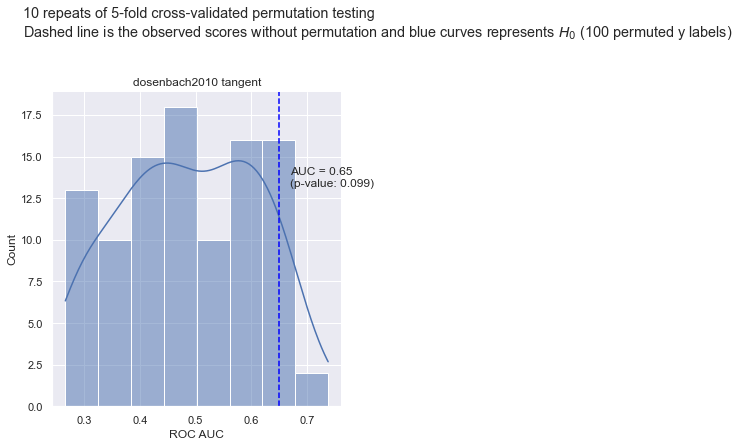

In [29]:

g = sns.displot(rnd_scores, kde=True)
g.set(xlabel='ROC AUC')
g.ax.set_title('{} {}'.format(ATLAS, CONNECTIVITY_MEASURE))

plt.axvline(obs_score, ls='--', color='blue')


plt.text(x=obs_score + .02,
        y=plt.gca().get_ylim()[1] * .7,
        s=f'AUC = {obs_score:.2f}\n(p-value: {obs_pvalue:.3f})')

plt.suptitle(f'{cv.n_repeats} repeats of 5-fold cross-validated permutation testing\n'
             f'Dashed line is the observed scores without permutation '
             f'and blue curves represents $H_0$ (100 permuted y labels)',
             y=1.2, x=.08, ha='left')
plt.show()

Now, we visualize the factor loadings against the features.

In [30]:
palt = dict(zip(
  network_names['network'].unique(),
  sns.color_palette('Set1', network_names['network'].nunique())))

network_colors = network_names['network'].apply(lambda x: pd.Series((palt[x], x)))
network_colors.rename(columns={0:'color', 1:'network'}, inplace=True)
network_colors.reset_index(drop=True, inplace=True)
network_colors.drop_duplicates(inplace=True)
network_colors.set_index('network', inplace=True)


feature_colors = {}
for k,v in factors_model.items():
  for vv in v:
    feature_colors[vv] = network_colors.loc[k, 'color']

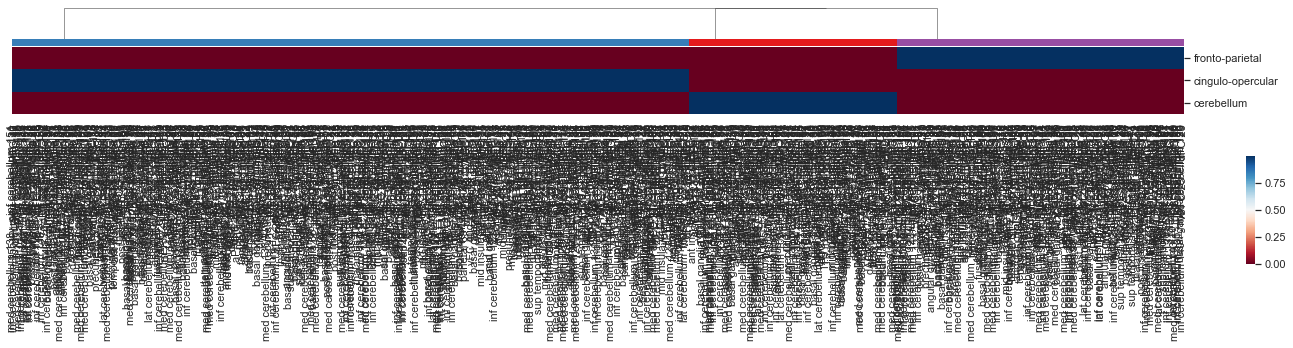

In [31]:
fa_loadings = pd.DataFrame(
  cfa.loadings_,
  index=feature_names,
  columns=list(factors_model.keys())
)

# fig, ax = plt.subplots(figsize=(30,3))
# sns.heatmap(fa_loadings.T, ax=ax)


g = sns.clustermap(fa_loadings.T, figsize=(25,5),
               row_cluster=False, col_cluster=True,
               cbar_pos=(.975, .25, 0.005, 0.3),
               cmap='RdBu',
               xticklabels=1,
               colors_ratio=.07,
               dendrogram_ratio=.3,
               col_colors=list(feature_colors.values()),)

g.ax_row_dendrogram.set_visible(False)

# to rotate y labels
# g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=45, ha='right', fontsize=10)

plt.show()

We can also report the importance of each factor, that is coefficient of the linear SVM classifier we trained above.


It can be seen as a measure of the importance of each factor to the classification task.

In [36]:
for i, (net, feats) in enumerate(factors_model.items()):
  coef = opt.best_estimator_['clf'].coef_[0][i]
  print(f'{net}:\n'
        f'\tSVM coef: {coef:.2f}\n'
        f'\tfeatures: {", ".join(feats)}')

fronto-parietal:
	SVM coef: 32.67
	features: dlPFC 24 ↔ vPFC 23, dlPFC 24 ↔ dFC 29, dlPFC 24 ↔ IPL 96, dlPFC 24 ↔ IPL 104, dlPFC 24 ↔ dlPFC 16, dlPFC 24 ↔ vent aPFC 10, dlPFC 24 ↔ dFC 36, dlPFC 24 ↔ IPS 116, dlPFC 24 ↔ IPS 114, dlPFC 24 ↔ aPFC 2, dlPFC 24 ↔ IPL 88, dlPFC 24 ↔ vlPFC 12, dlPFC 24 ↔ aPFC 3, dlPFC 24 ↔ ACC 21, dlPFC 24 ↔ vent aPFC 9, dlPFC 24 ↔ post parietal 99, dlPFC 24 ↔ dFC 34, dlPFC 24 ↔ IPL 101, dlPFC 24 ↔ dlPFC 22, dlPFC 24 ↔ IPL 107, vPFC 23 ↔ dFC 29, vPFC 23 ↔ IPL 96, vPFC 23 ↔ IPL 104, vPFC 23 ↔ dlPFC 16, vPFC 23 ↔ vent aPFC 10, vPFC 23 ↔ dFC 36, vPFC 23 ↔ IPS 116, vPFC 23 ↔ IPS 114, vPFC 23 ↔ aPFC 2, vPFC 23 ↔ IPL 88, vPFC 23 ↔ vlPFC 12, vPFC 23 ↔ aPFC 3, vPFC 23 ↔ ACC 21, vPFC 23 ↔ vent aPFC 9, vPFC 23 ↔ post parietal 99, vPFC 23 ↔ dFC 34, vPFC 23 ↔ IPL 101, vPFC 23 ↔ dlPFC 22, vPFC 23 ↔ IPL 107, dFC 29 ↔ IPL 96, dFC 29 ↔ IPL 104, dFC 29 ↔ dlPFC 16, dFC 29 ↔ vent aPFC 10, dFC 29 ↔ dFC 36, dFC 29 ↔ IPS 116, dFC 29 ↔ IPS 114, dFC 29 ↔ aPFC 2, dFC 29 ↔ IPL 88, dFC 

### Explain the model

#### SHAP

We can explain the contribution of each factor to the classification score by plotting their SHAP values.

100%|██████████| 500/500 [00:04<00:00, 110.00it/s]


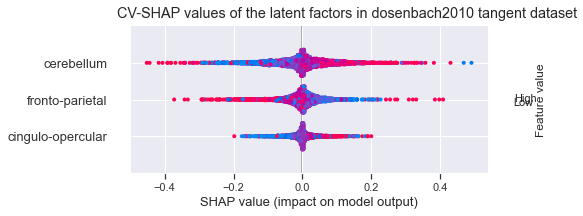

In [37]:
import shap

cv = model_selection.RepeatedStratifiedKFold(n_splits=5, n_repeats=100)
n_splits = cv.get_n_splits(X, y)

shap_values_cv = []
expected_value_cv = []
X_test_indices_cv = []
y_test_cv = []
y_pred_cv = []

model = opt.best_estimator_

for train, test in tqdm(cv.split(X, y), total=n_splits):

  model.fit(X_cfa[train], y[train])
  y_pred = model.predict(X_cfa[test])
  explainer = shap.Explainer(model.predict_proba,
                            X_cfa[train],
                            feature_names=list(factors_model.keys()))

  shap_values = explainer(X_cfa[test])

  shap_values_cv.append(shap_values)
  # expected_value_cv.append(explainer.expected_value)
  X_test_indices_cv.append(test)
  y_test_cv.append(y[test])
  y_pred_cv.append(y_pred)

# merge CV data
y_test = np.hstack(y_test_cv)
y_pred = np.hstack(y_pred_cv)

# merge CV SHAPs
shap_values = shap.Explanation(
  values = np.vstack([sh.values[...,1] for sh in shap_values_cv]),
  base_values = np.hstack([sh.base_values[...,1] for sh in shap_values_cv]),
  data = np.vstack([sh.data for sh in shap_values_cv]),
  feature_names=shap_values_cv[0].feature_names,
  compute_time=np.sum([sh.compute_time for sh in shap_values_cv]),
  output_names=y_encoder.classes_,
  output_indexes=y_pred,
)


shap.plots.beeswarm(shap_values, show=False)
plt.suptitle('CV-SHAP values of the latent factors in {} {} dataset'.format(ATLAS, CONNECTIVITY_MEASURE))
plt.show()

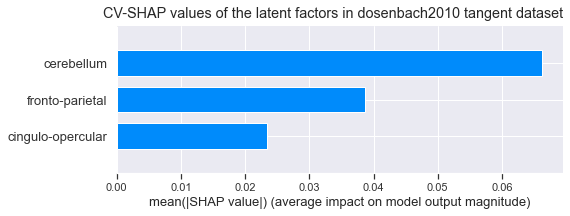

In [38]:
shap.summary_plot(deepcopy(shap_values), plot_type='bar', show=False)

plt.suptitle('CV-SHAP values of the latent factors in {} {} dataset'.format(ATLAS, CONNECTIVITY_MEASURE))
plt.show()

#### Permutation Importance

Another feature importance method is the permutation analysis, where we permute the feature values and compute the classification score. The effect of a feature on the classification is then plotted.

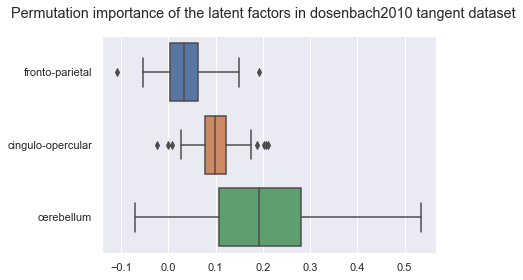

In [39]:
from sklearn.inspection import permutation_importance

opt.best_estimator_.fit(X_cfa, y)
perm_imp_result = permutation_importance(opt.best_estimator_, X_cfa, y, 
                                         n_repeats=100,
                                         scoring='roc_auc', n_jobs=-1)

perm_sorted_idx = perm_imp_result.importances_mean.argsort()

perm_df = pd.DataFrame(perm_imp_result.importances[perm_sorted_idx].T,
             columns=factors_model.keys())
sns.boxplot(
    data=perm_df,
    orient='horizontal',
#     labels=feature_names[perm_sorted_idx],
)

plt.suptitle('Permutation importance of the latent factors in {} {} dataset'.format(ATLAS, CONNECTIVITY_MEASURE))
plt.show()